

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Practical Assignment 3
    <br>
     Hidden Markov Models -Bayes Net <br>
<font color=696880 size=4>
Amirardalan Dehghanpour


Kiarash Sanei 402106156

# HMM Assignment

 –Sequence Modeling with Hidden Markov Models (HMM)

## Part 1: HMM Models


Introduce the concept of Hidden Markov Models (HMMs) and their applications in sequence modeling.

### -What is an HMM?
A Hidden Markov Model is a statistical model that represents systems with:
1. **Hidden states** – not directly observable (e.g., phonemes, weather conditions, gene regions).
2. **Observable outputs** – emitted signals or features (e.g., audio features, weather observations).

### - Key Components of an HMM:
- **States (Z)**: Hidden variables (e.g., phonemes in speech recognition).
- **Observations (X)**: Observable features (e.g., MFCCs from audio).
- **Initial Probabilities (π)**: Probability of starting in a particular state.
- **Transition Probabilities (A)**: Probability of moving from one state to another.
- **Emission Probabilities (B)**: Probability of observing a value given a state.

### -HMM Process Overview:
At each time step `t`, the system:
1. Transitions from one state to another using **transition probability A**
2. Emits an observation using **emission probability B**

### - Why Use HMMs?
HMMs are useful for modeling sequential data where the underlying structure is hidden but can be inferred from observations.

#### Example Applications:
- **Speech Recognition** – Infer phonemes from audio features
- **Natural Language Processing** – POS tagging, named entity recognition
- **Bioinformatics** – Identify coding vs. non-coding DNA regions
- **Finance** – Regime detection in time series

---

 In this part, we will:
- Work with dna datasets
- Extract HMM parameters from data
- Implement HMM algorithms from scratch
- Visualize results to understand hidden sequences



## Part 2: Extract HMM Parameters from DNA Dataset ##

In this section, you'll use a labeled DNA dataset to extract the core parameters of a Hidden Markov Model:
- **Initial Probabilities** – likelihood of starting in a specific hidden state
- **Transition Matrix** – probabilities of switching from one hidden state to another
- **Emission Matrix** – probabilities of emitting a specific observation given the hidden state

We are given labeled sequences of DNA nucleotides with associated hidden states (`Coding` or `NonCoding`). Using this, we can compute the HMM parameters as follows:


####  Initial Probabilities (π)
- For each sequence, check the **first position** (Position == 1).
- Count how many times each hidden state appears at the start.
- Normalize the counts to get the starting probability distribution.

####  Transition Probabilities (A)
- For each sequence, look at every **pair of consecutive states** (from Position _t_ to _t+1_).
- Count how often each transition occurs (e.g., Coding → Coding, Coding → NonCoding).
- For each state, normalize its outgoing transition counts to sum to 1.

####  Emission Probabilities (B)
- For each state, count how frequently it emits each nucleotide (A, C, G, T).
- Normalize these counts within each state.

This method is based on **maximum likelihood estimation(MLE)** using frequency counts, which is valid because we have access to the true hidden states.
These parameters will be used in later for performing inference (Forward/Viterbi).



 ## Load the Dataset ##

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('dna_dataset.csv')

df.head()

,Sequence_ID,Position,Nucleotide,State
0,1,1,A,Coding
1,1,2,G,NonCoding
2,1,3,G,Coding
3,1,4,A,NonCoding
4,1,5,T,Coding


## Identify Unique States and Observations ##

In [3]:
states = df['State'].unique()

observations = df['Nucleotide'].unique()

print("States:", states)
print("Observations:", observations)

States: ['Coding' 'NonCoding']
Observations: ['A' 'G' 'T' 'C']


## Estimate Initial Probabilities (π) ##

In [4]:
first_states = df.groupby('Sequence_ID').first()['State']

initial_counts = first_states.value_counts()

initial_probs = initial_counts / initial_counts.sum()

print("Initial Probabilities (π):")
for state, prob in initial_probs.items():
    print(state, "→", prob)

Initial Probabilities (π):
NonCoding → 0.51
Coding → 0.49


## Estimate Transition Probabilities (A) ##

In [5]:
df['Next_State'] = df.groupby('Sequence_ID')['State'].shift(-1)

transitions = df.dropna(subset=['Next_State'])

transition_counts = transitions.groupby(['State', 'Next_State']).size().unstack(fill_value=0)

transition_probs = transition_counts.div(transition_counts.sum(axis=1), axis=0).to_dict(orient='index')

print("Transition Probabilities (A):")
for from_state, to_probs in transition_probs.items():
    print(from_state, "→", to_probs)

Transition Probabilities (A):
Coding → {'Coding': 0.4450775142440705, 'NonCoding': 0.5549224857559295}
NonCoding → {'Coding': 0.5823615160349854, 'NonCoding': 0.4176384839650146}


## Estimate Emission Probabilities (B) ##

In [6]:
emission_counts = df.groupby(['State', 'Nucleotide']).size().unstack(fill_value=0)

emission_probs = emission_counts.div(emission_counts.sum(axis=1), axis=0).to_dict(orient='index')

print("Emission Probabilities (B):")
for state, probs in emission_probs.items():
    print(state, "→", probs)

Emission Probabilities (B):
Coding → {'A': 0.2556261195245074, 'C': 0.2506757857026543, 'G': 0.24950333821853118, 'T': 0.2441947565543071}
NonCoding → {'A': 0.35343915343915344, 'C': 0.14794333504010923, 'G': 0.1501962792285373, 'T': 0.3484212322922}


## Part 4: Forward Algorithm (Filtering with Elapse Time + Observation)

The **Forward Algorithm** helps us compute the probability of an observation sequence in a Hidden Markov Model (HMM). It also gives us the belief about the system's hidden state at each time step.

To do this, it recursively applies two updates at each time step `t`:


###  Step 1: Elapse Time (Prediction)
Predict the probability of being in each hidden state at time `t`, before seeing the new observation:

$$
P(x_t | e_{1:t-1}) = \sum_{x_{t-1}} P(x_t | x_{t-1}) \cdot P(x_{t-1} | e_{1:t-1})
$$

This uses the **transition probabilities (A)** and previous beliefs.


###  Step 2: Observation Update (Bayesian Update)
Once we see the new observation `e_t`, we update our beliefs:

$$
P(x_t | e_{1:t}) \propto P(e_t | x_t) \cdot P(x_t | e_{1:t-1})
$$

This uses the **emission probabilities (B)** and normalizes the result.


### Final Result:
- We maintain a belief `α_t(x)` for each state `x` at every time step.
- We can compute the total probability of the sequence by summing the final α values.



In [7]:
def elapse_time(prior, transition_probs, states):
    prediction = {}
    
    for state in states:
        prediction[state] = sum(
            prior[prev_state] * transition_probs[prev_state].get(state, 0)
            for prev_state in states
        )
    
    return prediction

In [8]:
def observe(predicted, observation, emission_probs, states):
    updated = {}

    for state in states:
        updated[state] = predicted[state] * emission_probs[state].get(observation, 0)
    
    total_prob = sum(updated.values())
    
    if total_prob > 0:
        updated = {state: prob / total_prob for state, prob in updated.items()}
    
    return updated

In [9]:
def forward_algorithm(observation_sequence, states, start_probs, transition_probs, emission_probs):
    alpha_list = []

    alpha_0 = {}
    for state in states:
        alpha_0[state] = start_probs.get(state, 0) * emission_probs[state].get(observation_sequence[0], 0)

    total_prob_0 = sum(alpha_0.values())
    if total_prob_0 > 0:
        alpha_0 = {state: prob / total_prob_0 for state, prob in alpha_0.items()}
    
    alpha_list.append(alpha_0)

    for t in range(1, len(observation_sequence)):
        observation = observation_sequence[t]
        alpha_t = {}
        
        for state in states:
            alpha_t[state] = sum(
                alpha_list[t-1][prev_state] * transition_probs[prev_state].get(state, 0) * emission_probs[state].get(observation, 0)
                for prev_state in states
            )

        total_prob_t = sum(alpha_t.values())
        if total_prob_t > 0:
            alpha_t = {state: prob / total_prob_t for state, prob in alpha_t.items()}
        
        alpha_list.append(alpha_t)

    sequence_prob = sum(alpha_list[-1].values())
    
    return alpha_list, sequence_prob

In [10]:
test_sequence = ['A','C','C','T','T','T','A','G']

alpha_vals, prob = forward_algorithm(
    test_sequence,
    states,
    initial_probs,
    transition_probs,
    emission_probs
)

print(f"\nTotal probability of sequence {test_sequence}: {prob:.6f}")
print("\nBelief at final time step:")
for state, p in alpha_vals[-1].items():
    print(f"P({state}) = {p:.4f}")



Total probability of sequence ['A', 'C', 'C', 'T', 'T', 'T', 'A', 'G']: 1.000000

Belief at final time step:
P(Coding) = 0.6443
P(NonCoding) = 0.3557


## Part 5: Viterbi Algorithm – Most Likely State Sequence

While the Forward Algorithm gives us the probability of a sequence of observations, the **Viterbi Algorithm** answers a different question:

> What is the **most likely sequence of hidden states** that could have generated this observation sequence?



The Viterbi Algorithm is a dynamic programming approach. At each time step `t`, it keeps track of:

- The **highest probability path** to each state.
- A **backpointer** that tells us which state led to that one.

###  Two Main Steps:

1. **Recursion (Forward Pass):**
$$
\delta_t(s) = \max_{s'} [\delta_{t-1}(s') \cdot P(s | s')] \cdot P(obs_t | s)
$$

2. **Backtracking (Backward Pass):**
$$
\text{Backtrace from final best state} \rightarrow \text{recover most likely path}
$$





In [11]:
def viterbi(obs, states, start_p, trans_p, emit_p):
    V = [{}]
    path = {}

    for state in states:
        V[0][state] = start_p[state] * emit_p[state][obs[0]]
        path[state] = [state]
        
    for t in range(1, len(obs)):
        V.append({})
        new_path = {}

        for curr_state in states:
            (prob, prev_state) = max(
                (V[t - 1][prev_state] * trans_p[prev_state][curr_state] * emit_p[curr_state][obs[t]], prev_state)
                for prev_state in states
            )
            V[t][curr_state] = prob
            new_path[curr_state] = path[prev_state] + [curr_state]

        path = new_path

    n = len(obs) - 1
    (prob, state) = max((V[n][state], state) for state in states)
    return prob, path[state]

In [12]:
obs_seq = ['A', 'C', 'G', 'T', 'A','A', 'C', 'C', 'C', 'A']

prob, most_likely_path = viterbi(
    obs_seq,
    states,
    initial_probs,
    transition_probs,
    emission_probs
)

print("Observation sequence:", obs_seq)
print("Most likely state sequence:", most_likely_path)
print("Probability of this path:", prob)

Observation sequence: ['A', 'C', 'G', 'T', 'A', 'A', 'C', 'C', 'C', 'A']
Most likely state sequence: ['NonCoding', 'Coding', 'Coding', 'NonCoding', 'Coding', 'NonCoding', 'Coding', 'Coding', 'Coding', 'NonCoding']
Probability of this path: 5.879383986938688e-09


## Part 6: Visualizing the Most Likely Hidden State Sequence (Viterbi Path)

After using the Viterbi algorithm, we get the **most likely sequence of hidden states** that could have produced the given observations.

In this part, we'll:
1. Visually display the Viterbi path over time.
2. Compare it with the **true hidden state sequence** (if known).
3. Visualize it on top of the **Forward Algorithm belief heatmap**.

This helps understand where the model is confident, where it might be uncertain, and how accurate the predictions are.


In [13]:
import matplotlib.pyplot as plt

def plot_viterbi_path(viterbi_path, states, title="Viterbi Most Likely Path"):
    time_steps = list(range(len(viterbi_path)))
    state_to_num = {state: i for i, state in enumerate(states)}
    state_nums = [state_to_num[state] for state in viterbi_path]

    plt.figure(figsize=(12, 2))
    plt.plot(time_steps, state_nums, drawstyle='steps-post', marker='o', linestyle='-', color='blue')
    plt.yticks(ticks=list(state_to_num.values()), labels=states)
    plt.xticks(ticks=time_steps)
    plt.xlabel("Time Step")
    plt.ylabel("State")
    plt.title(title)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

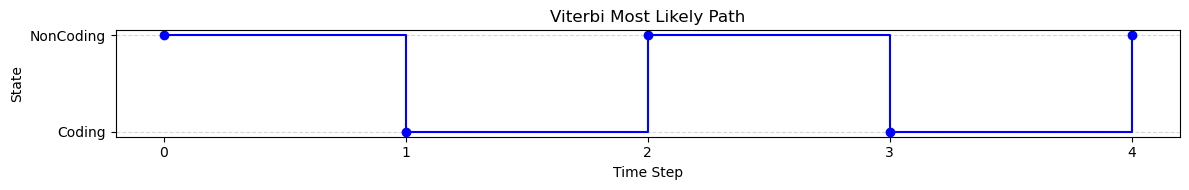

In [15]:
# Run Viterbi on example observation sequence
obs_seq = ['A', 'C', 'T', 'G', 'A']
prob, viterbi_path = viterbi(obs_seq, states, initial_probs, transition_probs, emission_probs)

# Plot the path
plot_viterbi_path(viterbi_path, states)

# Bayesian Networks

In this assignment, we will work with a Bayesian Network based on a scenario: **a group of friends deciding whether to order pizza** and how that decision, along with other factors, affects their evening satisfaction.

We'll learn how to:
- Represent a Bayesian Network
- Define its conditional probability tables (CPTs)
- Implement inference algorithms

---

## Scenario

Imagine a group of friends planning their evening. They may or may not be hungry. It might be a weekend. These factors influence whether they decide to order pizza. If pizza is ordered **and** friends are free, they might plan a movie night. The presence of a movie night then affects how satisfied they are.

---

## 🔍 Variables

| Variable | Description | Values |
|----------|-------------|--------|
| `H` | It's a hungry day | {True, False} |
| `W` | It's the weekend | {True, False} |
| `P` | They order pizza | {True, False} |
| `F` | Friends are free | {True, False} |
| `M` | Movie night is planned | {True, False} |
| `S` | Satisfaction level | {'high', 'medium', 'low'} |

---

## 🔗 Network Structure

The relationships among the variables and their conditional probablities follow these tables:

### P(H) — Hungry
| H     | P(H) |
|-------|------|
| True  | 0.6  |
| False | 0.4  |

### P(W) — Weekend
| W     | P(W) |
|-------|------|
| True  | 0.3  |
| False | 0.7  |

### P(F) — Friends Free
| F     | P(F) |
|-------|------|
| True  | 0.8  |
| False | 0.2  |

### P(P | H, W) — Pizza
| H     | W     | P(P=True) | P(P=False) |
|-------|-------|-----------|------------|
| True  | True  | 0.95      | 0.05       |
| True  | False | 0.7       | 0.3        |
| False | True  | 0.5       | 0.5        |
| False | False | 0.1       | 0.9        |

### P(M | P, F) — Movie Night
| P     | F     | P(M=True) | P(M=False) |
|-------|-------|-----------|------------|
| True  | True  | 0.9       | 0.1        |
| True  | False | 0.4       | 0.6        |
| False | True  | 0.6       | 0.4        |
| False | False | 0.2       | 0.8        |

### P(S | M) — Satisfaction
| M     | S        | P(S)   |
|-------|----------|--------|
| True  | high     | 0.7    |
|       | medium   | 0.25   |
|       | low      | 0.05   |
| False | high     | 0.1    |
|       | medium   | 0.3    |
|       | low      | 0.6    |




###  Step 1: Define and Visualize the Bayesian Network
#### Your task in this step:
##### 1. Draw the Bayesian Network using networkx and matplotlib
##### 2. Create a dictionary called `bayes_net` that stores all variables, their parents, and their CPTs

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

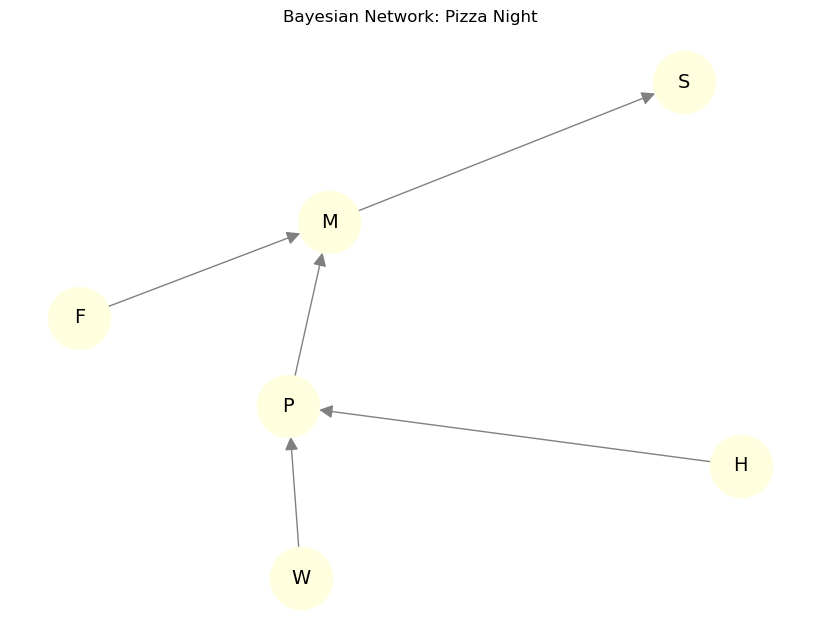

P(P=True | H=True, W=False): 0.7


In [15]:
G = nx.DiGraph()

G.add_edge('H', 'P')
G.add_edge('W', 'P')
G.add_edge('P', 'M')
G.add_edge('F', 'M')
G.add_edge('M', 'S')

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightyellow',
        font_size=14, edge_color='gray', arrowsize=20)
plt.title("Bayesian Network: Pizza Night")
plt.show()

bayes_net = {
    'H': {
        'parents': [],
        'cpt': {
            True: 0.6,
            False: 0.4
        }
    },
    'W': {
        'parents': [],
        'cpt': {
            True: 0.3,
            False: 0.7
        }
    },
    'F': {
        'parents': [],
        'cpt': {   
            True: 0.8,
            False: 0.2
        }
    },
    'P': {
        'parents': ['H','W'],
        'cpt': {
            (True, True): {True: 0.95, False: 0.05},
            (True, False): {True: 0.7, False: 0.3},
            (False, True): {True: 0.5, False: 0.5},
            (False, False): {True: 0.1, False: 0.9}
        }
    },
    'M': {
        'parents':['P','F'],
        'cpt': {
            (True, True): {True: 0.9, False: 0.1},
            (True, False): {True: 0.4, False: 0.6},
            (False, True): {True: 0.6, False: 0.4},
            (False, False): {True: 0.2, False: 0.8}
        }
    },
    'S': {
        'parents':['M'],
        'cpt': {
            (True,): {"high": 0.7, "medium": 0.25, "low": 0.05},
            (False,): {"high": 0.1, "medium": 0.3, "low": 0.6}
        }
    }
}

def get_prob(var, value, evidence, bayes_net):
    node = bayes_net[var]
    parents = node['parents']
    cpt = node['cpt']

    if not parents:
        return cpt[value]
    else:
        try:
            key = tuple(evidence[parent] for parent in parents)
        except KeyError as e:
            raise ValueError(f"Missing parent '{e.args[0]}' for variable '{var}' in evidence.")

        return cpt[key][value]

result = get_prob('P', True, {'H': True, 'W': False}, bayes_net)
print("P(P=True | H=True, W=False):", result)

# Step 2: Inference by Enumeration

In this step, you'll implement **exact inference** in a Bayesian Network using the **enumeration algorithm**.

---

##  Goal :

We want to compute the probability of a **query variable** given some **evidence**.  
For example:

$$
P(S = \text{high} \mid H = \text{True}, W = \text{True})
$$

To do this, we'll use:

1. **A recursive function `enumerate_all`**  
   - Loops through all hidden variables and sums over them
   - Multiplies conditional probabilities using the Bayesian Network

2. **A main function `query_enum`**  
   - Computes the numerator: probability of the query value given evidence
   - Computes the denominator: normalization over all possible values of the query variable
   - Returns the final **normalized probability**

---






In [42]:
variables = ['H', 'W', 'F', 'P', 'M', 'S']

def enumerate_all(remaining_vars, evidence, bayes_net):
    if not remaining_vars:
        return 1.0

    current_var = remaining_vars[0]
    next_vars = remaining_vars[1:]

    if current_var in evidence:
        value = evidence[current_var]
        probability = get_prob(current_var, value, evidence, bayes_net)
        return probability * enumerate_all(next_vars, evidence, bayes_net)
    else:
        total_prob = 0.0
        cpt = bayes_net[current_var]['cpt']
        sample_entry = next(iter(cpt.values()))

        if isinstance(sample_entry, dict):
            values = list(sample_entry.keys())
        else:
            values = [True, False]

        for value in values:
            updated_evidence = dict(evidence)
            updated_evidence[current_var] = value
            probability = get_prob(current_var, value, updated_evidence, bayes_net)
            total_prob += probability * enumerate_all(next_vars, updated_evidence, bayes_net)

        return total_prob

def get_domain(var, bayes_net):
    cpt = bayes_net[var]['cpt']
    if isinstance(next(iter(cpt.values())), dict):
        sample_key = next(iter(cpt))
        return list(cpt[sample_key].keys())
    else:
        return list(cpt.keys())


def query_enum(query_var, query_val, evidence, bayes_net):
    distribution = {}

    for val in get_domain(query_var, bayes_net):
        extended_evidence = evidence.copy()
        extended_evidence[query_var] = val
        distribution[val] = enumerate_all(variables, extended_evidence, bayes_net)
    
    total = sum(distribution.values())
    if total == 0:
        raise ValueError("Total probability is zero — check evidence for inconsistencies.")
    
    normalized_prob = distribution[query_val] / total
    return normalized_prob


In [43]:
result = query_enum('S', 'high', {'H': True, 'W': True}, bayes_net)
print(f"P(S = 'high' | H=True, W=True) = {result:.4f}")

P(S = 'high' | H=True, W=True) = 0.5716


#  Step 3: Inference with Variable Elimination

In this step, you will implement **inference using Variable Elimination** — an exact, more efficient alternative to Enumeration.

---

## Core Ideas:

- Instead of computing the full joint distribution, we work with **factors**.
- A factor is a table mapping variable assignments to probabilities.
- We **join factors** together (multiplication).
- We **eliminate hidden variables** (sum them out).
- At the end, we normalize the final factor.

---

## Inputs
- `query_var`: The variable we're asking about (e.g. `'S'`)
- `query_val`: The value we want (e.g. `'high'`)
- `evidence`: Observed variables
- `bayes_net`: The full Bayesian Network

---

## What You’ll Implement
1. **Factor Construction**: Build initial factors from CPTs.
2. **Restrict for Evidence**: Incorporate evidence early by pruning CPTs.
3. **Join**: Combine factors that mention the same variable.
4. **Eliminate**: Marginalize out variables not in the query or evidence.
5. **Normalize**: Get valid probability distribution.

---



In [44]:
from itertools import product

def make_factor(var, bayes_net, evidence):
    cpt = bayes_net[var]['cpt']
    parents = bayes_net[var]['parents']
    factor_vars = parents + [var]
    factor_table = {}

    domains = [get_domain(v, bayes_net) for v in factor_vars]

    for assignment in product(*domains):
        assignment_dict = dict(zip(factor_vars, assignment))

        if any(evidence.get(k) != v for k, v in assignment_dict.items() if k in evidence):
            continue

        parent_vals = tuple(assignment_dict[p] for p in parents) if parents else None
        var_val = assignment_dict[var]

        if parents:
            prob = cpt[parent_vals][var_val]
        else:
            prob = cpt[var_val]

        factor_table[assignment] = prob

    return {'vars': factor_vars, 'table': factor_table}

def join_factors(f1, f2):
    vars1, vars2 = f1['vars'], f2['vars']
    all_vars = list(dict.fromkeys(vars1 + vars2))
    table = {}

    domains = {var: get_domain(var, bayes_net) for var in all_vars}

    for assignment in product(*[domains[v] for v in all_vars]):
        assignment_dict = dict(zip(all_vars, assignment))
        key1 = tuple(assignment_dict[v] for v in vars1)
        key2 = tuple(assignment_dict[v] for v in vars2)

        if key1 in f1['table'] and key2 in f2['table']:
            table[tuple(assignment_dict[v] for v in all_vars)] = \
                f1['table'][key1] * f2['table'][key2]

    return {'vars': all_vars, 'table': table}

def eliminate(var, factor):
    idx = factor['vars'].index(var)
    new_vars = [v for v in factor['vars'] if v != var]
    table = {}

    for assignment in factor['table']:
        new_assignment = tuple(v for i, v in enumerate(assignment) if i != idx)
        table[new_assignment] = table.get(new_assignment, 0) + factor['table'][assignment]

    return {'vars': new_vars, 'table': table}

def query_ve(query_var, query_val, evidence, bayes_net):
    factors = [make_factor(var, bayes_net, evidence) for var in bayes_net]

    hidden_vars = [v for v in bayes_net if v != query_var and v not in evidence]

    for var in hidden_vars:
        related = [f for f in factors if var in f['vars']]
        if not related:
            continue
        factors = [f for f in factors if f not in related]

        joined = related[0]
        for f in related[1:]:
            joined = join_factors(joined, f)
        reduced = eliminate(var, joined)
        factors.append(reduced)

    result = factors[0]
    for f in factors[1:]:
        result = join_factors(result, f)

    idx = result['vars'].index(query_var)
    total = 0
    probs = {}

    for assignment, prob in result['table'].items():
        val = assignment[idx]
        probs[val] = probs.get(val, 0) + prob
        total += prob

    return probs[query_val] / total if total != 0 else 0

In [45]:
result_ve = query_ve('S', 'high', {'H': True, 'W': True}, bayes_net)
print(f"P(S = 'high' | H=True, W=True) = {result_ve:.4f}")

P(S = 'high' | H=True, W=True) = 0.5716



## Compare Enumeration vs. Variable Elimination
Explain your answer in each question
1. Do both methods return the **same probability** for your chosen query and evidence? Why or why not?

2. Which method was **faster** in your tests? Provide the execution times.

3. Why is **Variable Elimination** usually more efficient than Enumeration, especially for larger networks?

4. Can you think of a scenario where Enumeration might be **simpler or more appropriate** to use than VE?

5. What would happen to the performance of each method if the number of variables doubled? Try to explain without coding it.


# Step 4: Approximate Inference with Sampling

In this part, you'll implement two approximate inference algorithms:
- **Rejection Sampling**
- **Likelihood Weighting**

These methods generate random samples from the Bayesian Network to estimate conditional probabilities.

---

##  Rejection Sampling

- Sample all variables from the prior distribution.
- **Reject** any sample that does not match the evidence.
- Among accepted samples, estimate the query probability.


---

##  Likelihood Weighting

- Sample variables in topological order.
- For **evidence variables**, **fix** their value and assign a **weight** equal to the likelihood of observing that value.
- For non-evidence variables, sample normally.
- Compute a weighted average of the query variable.

---

##  Your Tasks

Implement the following:
- `rejection_sampling(query_var, query_val, evidence, bayes_net, N)`
- `likelihood_weighting(query_var, query_val, evidence, bayes_net, N)`


In [46]:
import random

def rejection_sampling(query_var, query_val, evidence, bayes_net, N=1000):
    accepted = 0
    matching = 0

    for _ in range(N):
        sample = prior_sample(bayes_net)

        if all(sample.get(var) == val for var, val in evidence.items()):
            accepted += 1
            if sample[query_var] == query_val:
                matching += 1

    return matching / accepted if accepted > 0 else 0.0

def likelihood_weighting(query_var, query_val, evidence, bayes_net, N=1000):
    weighted_total = 0.0
    weighted_match = 0.0
    variables = list(bayes_net.keys())
    
    for _ in range(N):
        sample, weight = weighted_sample(bayes_net, evidence,variables)
        if sample[query_var] == query_val:
            weighted_match += weight
        weighted_total += weight

    return weighted_match / weighted_total if weighted_total > 0 else 0.0

def prior_sample(bayes_net):
    sample = {}
    for var in bayes_net:
        node = bayes_net[var]
        parents = node['parents']
        cpt = node['cpt']

        if parents:
            parent_values = tuple(sample[parent] for parent in parents)
            distribution = cpt[parent_values]
        else:
            distribution = cpt

        outcomes = list(distribution)
        probabilities = list(distribution.values())
        selected_value = random.choices(outcomes, probabilities)[0]
        sample[var] = selected_value

    return sample

def weighted_sample(bayes_net, evidence, variables):
    sample = {}
    total_weight = 1.0

    for var in variables:
        node = bayes_net[var]
        parents = node['parents']
        cpt = node['cpt']

        if parents:
            parent_values = tuple(sample[parent] for parent in parents)
            distribution = cpt[parent_values]
        else:
            distribution = cpt

        if var in evidence:
            observed_value = evidence[var]
            sample[var] = observed_value
            total_weight *= distribution[observed_value]
        else:
            outcomes = list(distribution.keys())
            probabilities = list(distribution.values())
            sample[var] = random.choices(outcomes, probabilities)[0]

    return sample, total_weight

In [47]:
evidence = {'H': True, 'W': True}
query = ('S', 'high')

res_reject = rejection_sampling(*query, evidence, bayes_net, N=10000)
res_lw = likelihood_weighting(*query, evidence, bayes_net, N=10000)

print(f"Rejection Sampling:      P(S='high' | H=True, W=True) ≈ {res_reject:.4f}")
print(f"Likelihood Weighting:    P(S='high' | H=True, W=True) ≈ {res_lw:.4f}")

Rejection Sampling:      P(S='high' | H=True, W=True) ≈ 0.5946
Likelihood Weighting:    P(S='high' | H=True, W=True) ≈ 0.5744


In [48]:
print("🔍 Testing Inference Methods with Various Queries:\n")

queries = [
    ('P', True, {'H': True, 'W': True}),
    ('P', True, {'H': False, 'W': False}),
    ('M', True, {'H': True, 'W': True}),
    ('M', False, {'F': False, 'P': False}),
    ('S', 'high', {'H': True, 'W': True}),
    ('S', 'low', {'H': False, 'W': False}),
]

for (q_var, q_val, evidence) in queries:
    print(f" Query: P({q_var} = {q_val} | {evidence})")

    res_enum = query_enum(q_var, q_val, evidence, bayes_net)
    print(f"  ➤ Enumeration:         {res_enum:.4f}")

    res_ve = query_ve(q_var, q_val, evidence, bayes_net)
    print(f"  ➤ Variable Elimination:{res_ve:.4f}")

    res_reject = rejection_sampling(q_var, q_val, evidence, bayes_net, N=5000)
    print(f"  ➤ Rejection Sampling:  {res_reject:.4f}")

    res_lw = likelihood_weighting(q_var, q_val, evidence, bayes_net, N=5000)
    print(f"  ➤ Likelihood Weighting:{res_lw:.4f}")

    print("-" * 60)

🔍 Testing Inference Methods with Various Queries:

 Query: P(P = True | {'H': True, 'W': True})
  ➤ Enumeration:         0.9500
  ➤ Variable Elimination:0.9500
  ➤ Rejection Sampling:  0.9356
  ➤ Likelihood Weighting:0.9454
------------------------------------------------------------
 Query: P(P = True | {'H': False, 'W': False})
  ➤ Enumeration:         0.1000
  ➤ Variable Elimination:0.1000
  ➤ Rejection Sampling:  0.0963
  ➤ Likelihood Weighting:0.0984
------------------------------------------------------------
 Query: P(M = True | {'H': True, 'W': True})
  ➤ Enumeration:         0.7860
  ➤ Variable Elimination:0.7860
  ➤ Rejection Sampling:  0.7965
  ➤ Likelihood Weighting:0.7884
------------------------------------------------------------
 Query: P(M = False | {'F': False, 'P': False})
  ➤ Enumeration:         0.8000
  ➤ Variable Elimination:0.8000
  ➤ Rejection Sampling:  0.8081
  ➤ Likelihood Weighting:0.7967
------------------------------------------------------------
 Query: 